<a href="https://colab.research.google.com/github/Michael-HK/Multi-task-Brain-Tumor-detection-and-segmentation/blob/main/brain_Tumor_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Dependencies**


In [ ]:
!pip install google.colab

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Aug  3 01:13:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler, CSVLogger, TensorBoard
from IPython.display import display
from tensorflow.keras import backend as KAA
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import os
import glob
import random
#from google.colab import files #library to upload files to colab notebook
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
#import utils
import os
from PIL import Image
from multiprocessing import Pool, cpu_count
from functools import partial

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! mkdir ~/.kaggle

In [ ]:
# upload the kaggle api:

!cp /content/drive/MyDrive/end_2_end_ML/kaggle.json ~/.kaggle/kaggle.json

cp: cannot create regular file '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# change file directory permission

! chmod 600 ~/.kaggle/kaggle.json

**Download Dataset from kaggle**

In [ ]:
# path to save the download data

%cd /content/drive/My Drive/end_2_end_ML/brain_tumor_model


/content/drive/My Drive/end_2_end_ML/brain_tumor_model


In [ ]:
#! kaggle datasets download prudvimacherla/braintumor-detection-healthcare

 97% 612M/629M [00:03<00:00, 152MB/s]
100% 629M/629M [00:03<00:00, 176MB/s]


In [ ]:
# unzip the file  braintumor-detection-healthcare.zip

from zipfile import ZipFile
file_name="/content/drive/My Drive/end_2_end_ML/brain_tumor_model/braintumor-detection-healthcare.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
!ls

brain_df.csv			     Healthcare_AI_Datasets  training.csv
braintumor-detection-healthcare.zip  log_dir		     utils.py
brain_Tumor_model.ipynb		     model_plot.png
Deeplab_multi-task.hdf5		     __pycache__


In [ ]:
# view the dataset
import utils
df = pd.read_csv('./Healthcare_AI_Datasets/Brain_MRI/label_data.csv')

**clean image and mask data files**

In [ ]:
# function to check if image is corrupt
def is_image_corrupt(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()
        return False  # The image is not corrupt
    except Exception as e:
        print(f"Corrupt image: {file_path}, Error: {e}")
        return True  # The image is corrupt

## Read file, check if the image exist and delete the corresponding path if it doesnt

DATA_DIR = "./Healthcare_AI_Datasets/Brain_MRI"  #the image and mask directory

def clean_image_data(df):
    df['image_path'] = df['image_path'].apply(lambda x: str(x))
    df['mask_path'] = df['mask_path'].apply(lambda x: str(x))

    # check for images
    for index, row in df.iterrows():
      image_path = os.path.join(DATA_DIR, row['image_path'])

      if not os.path.exists(image_path):
        df.drop(index, inplace=True)
#      if os.path.exists(image_path) and is_image_corrupt(image_path):
#        df.drop(index, inplace=True)
      # check

    # check if mask(annotation) is corrupt and remove the row
#    for index, row in df.iterrows():
#      mask_path = os.path.join(DATA_DIR, row['mask_path'])

      # remove path if it doesnt exist
#      if not os.path.exists(mask_path):
#        df.drop(index, inplace=True)
#      #remove path if it exist but the mask is corrupt
#      if os.path.exists(mask_path) and is_image_corrupt(mask_path):
#        df.drop(index, inplace=True)

    #save updated excel_file
    df.to_csv('./brain_df.csv', index=False)

#=====initiate the function

clean_image_data(df)

**Data visualization**

In [ ]:
# Use plotly to plot interactive bar chart
import plotly.graph_objects as go

#updated image file path
brain_df = pd.read_csv('./brain_df.csv')

def label_cat(a):
  if a == 0:
    return 'No Tumor'
  else:
    return 'Tumor present'

brain_df['label_cat'] = brain_df['label'].apply(label_cat)

fig = go.Figure([go.Bar(x = brain_df['label_cat'].value_counts().index, y = brain_df['label_cat'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(0,255,0)',
                  marker_line_width = 7, opacity = 0.6)
fig.show()

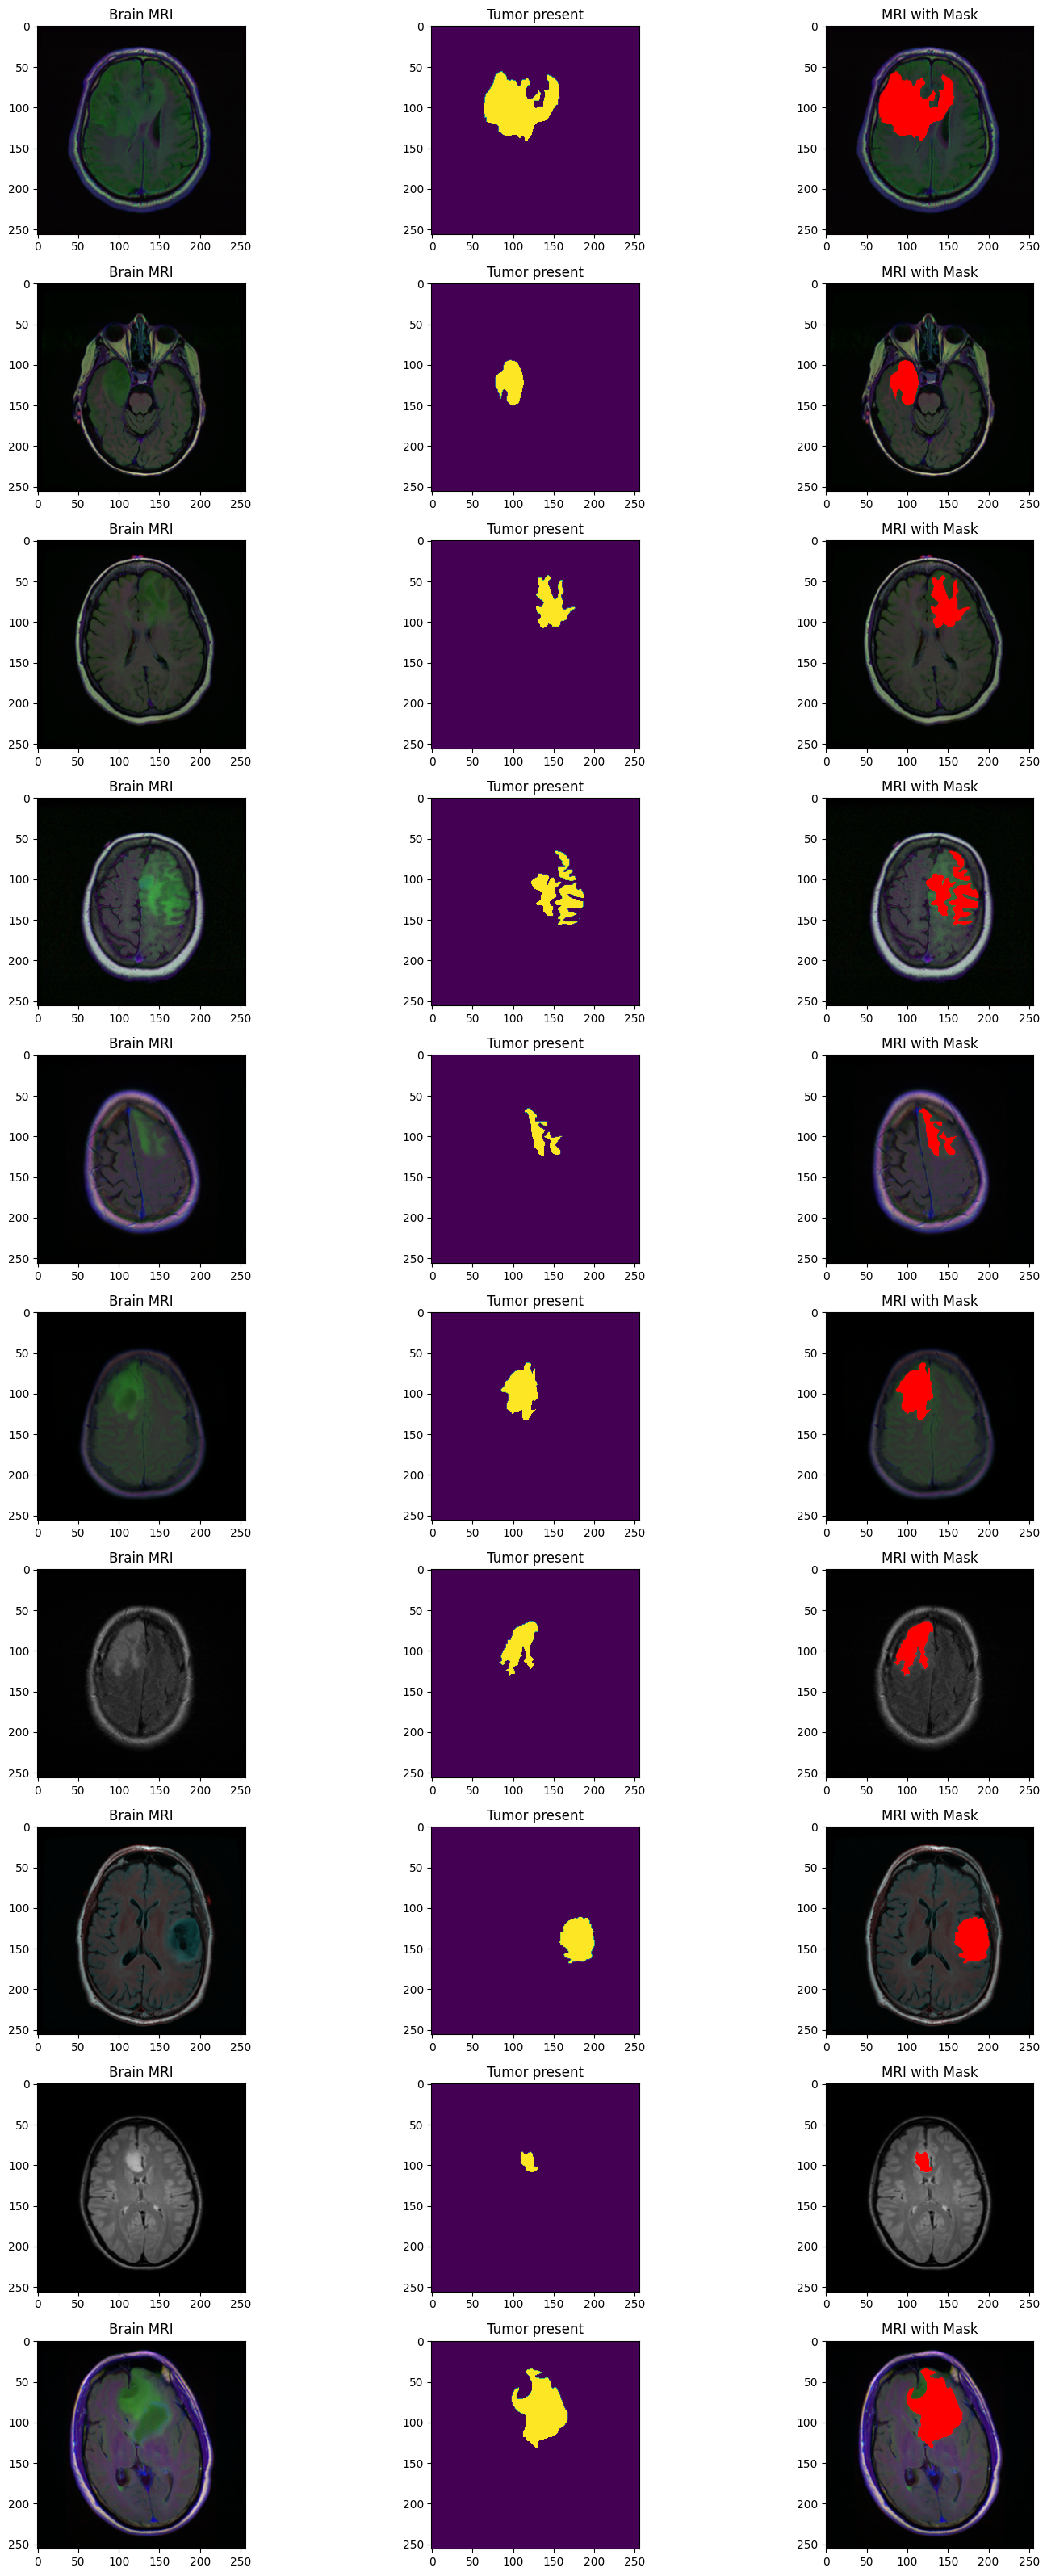

In [ ]:
# Visualize the images (MRI - Mask)
# import random
# fig, axs = plt.subplots(6,2, figsize=(16,32))
# count = 0
# h_indexes = brain_df['label'][brain_df['label']==1].index.tolist()
# for x in range(6):
#   i = random.choice(h_indexes)
#   axs[count][0].title.set_text("Brain MRI")
#   axs[count][0].imshow(cv2.imread('./Healthcare_AI_Datasets/Brain_MRI/' + brain_df.image_path[i]))
#   if brain_df['label'][i] == 0:
#     label = 'No Tumor'
#   else:
#     label = 'Tumor present'
#   axs[count][1].title.set_text(label)
#   axs[count][1].imshow(cv2.imread('./Healthcare_AI_Datasets/Brain_MRI/' + brain_df.mask_path[i]))
#   count += 1

# fig.tight_layout()

import random
fig, axs = plt.subplots(10,3, figsize=(16,32))
count = 0
h_indexes = brain_df['label'][brain_df['label']==1].index.tolist()
for x in range(10):
    i = random.choice(h_indexes)                 # select a random index
    mri_img=io.imread('./Healthcare_AI_Datasets/Brain_MRI/' + brain_df.image_path[i])

    axs[count][0].title.set_text("Brain MRI") # set title
    axs[count][0].imshow(mri_img) # show MRI
    if brain_df['label'][i] == 0:
      label = 'No Tumor'
    else:
      label = 'Tumor present'
    axs[count][1].title.set_text(label)
    msk_img=io.imread('./Healthcare_AI_Datasets/Brain_MRI/' + brain_df.mask_path[i])
    #axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
    axs[count][1].imshow(msk_img) # Show corresponding mask

    mri_img[msk_img==255] = (255,0,0)
    axs[count][2].title.set_text("MRI with Mask")
    axs[count][2].imshow(mri_img)
    count += 1

fig.tight_layout()


**Data preprocessing **

In [ ]:
from sklearn.model_selection import train_test_split

IMAGE_SIZE = 256
BATCH_SIZE = 16
NUM_CLASSES = 2
DATA_DIR = "./Healthcare_AI_Datasets/Brain_MRI"  #the image and mask directory , brain_df["label"]
#NUM_TRAIN_IMAGES = 1000
#NUM_VAL_IMAGES = 50


brain_df['image_path'] = brain_df['image_path'].apply(lambda x: str(x))
brain_df['mask_path'] = brain_df['mask_path'].apply(lambda x: str(x))
brain_df['label'] = brain_df['label'].apply(lambda x: str(x))

In [ ]:

#===========split dataset====================================

data = np.array(brain_df[["image_path","mask_path", "label"]])
train_data, val_data = train_test_split(data, random_state=104, test_size=0.20, shuffle=True)
X_val, X_test = train_test_split(val_data, random_state=42, test_size=0.05, shuffle=True)

#==========train images, masks, and labels======================================
train_images = train_data[:,0]
train_masks = train_data[:,1]
train_label = train_data[:,2]

##===========================validation data====================================
val_images = X_val[:,0]
val_masks = X_val[:,1]
val_label = X_val[:,2]

##===========================test data==========================================
test_images = X_test[:,0]
test_masks = X_test[:,1]
test_label = X_test[:,2]

print('number of data for training: ', len(train_images))
print('number of data for validation: ', len(val_images))
print('number of data for test: ', len(test_images))


number of data for training:  3137
number of data for validation:  745
number of data for test:  40


In [ ]:
## sampling the data in batches

#file path
image_train_path = [os.path.join(DATA_DIR, str(tr)) for tr in train_images]
mask_train_path =  [os.path.join(DATA_DIR, str(tr)) for tr in train_masks]
image_val_path = [os.path.join(DATA_DIR, str(tr)) for tr in val_images]
mask_val_path =  [os.path.join(DATA_DIR, str(tr)) for tr in val_masks]

image_test_path = [os.path.join(DATA_DIR, str(tr)) for tr in test_images]
mask_test_path  = [os.path.join(DATA_DIR, str(tr)) for tr in test_masks]

####================== load data in batches for training =======================
from keras.utils import to_categorical

def label_encoder(train_label):
  n_classes = len(np.unique(train_label))
  label = to_categorical(train_label, num_classes=n_classes)
  return label



In [ ]:
import keras
import math
import cv2
import numpy as np

class DataGenerator(keras.utils.Sequence):
    def __init__(self, image_filenames, mask_filenames, train_label, batch_size=32):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.batch_size = batch_size
        self.label = label_encoder(train_label)
        self.num_samples = len(image_filenames)

    def __len__(self):
        return math.ceil(self.num_samples / self.batch_size)

    def __getitem__(self, idx):
        batch_image_filenames = self.image_filenames[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_mask_filenames = self.mask_filenames[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_label = self.label[idx * self.batch_size: (idx + 1) * self.batch_size]

        batch_x = [self.preprocess_image(file_name) for file_name in batch_image_filenames]
        batch_x = np.array(batch_x)

        batch_mask = [self.preprocess_mask(file_name) for file_name in batch_mask_filenames]
        batch_mask = np.array(batch_mask)

        return batch_x, [np.array(batch_label), batch_mask]

    def on_epoch_end(self):
        # Shuffle the data after each epoch
        indices = np.arange(self.num_samples)
        np.random.shuffle(indices)
        self.image_filenames = [self.image_filenames[i] for i in indices]
        self.mask_filenames = [self.mask_filenames[i] for i in indices]
        self.label = self.label[indices]

    def preprocess_image(self, file_name):
        image = cv2.imread(file_name)
        desired_shape = (256, 256)
        resized_image = cv2.resize(image, desired_shape)
        image_array = np.array(resized_image)
        #batched_image = np.expand_dims(image_array, axis=0)
        preprocessed_image = tf.keras.applications.resnet50.preprocess_input(image_array)
        return preprocessed_image

    def preprocess_mask(self, file_name):
        mask = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
        desired_shape = (256, 256)
        resized_mask = cv2.resize(mask, desired_shape)
        _, thresholded_mask = cv2.threshold(resized_mask, 1, 1, cv2.THRESH_BINARY)
        return thresholded_mask


In [ ]:
import numpy as np
import tensorflow as tf
import keras.utils
import math
from PIL import Image
from tensorflow.keras.applications.resnet50 import preprocess_input

##========== using tensorflow without openCV==================

class tf_DataGenerator(keras.utils.Sequence):
    def __init__(self, image_filenames, mask_filenames, train_label, batch_size=32):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.batch_size = batch_size
        self.label = label_encoder(train_label)
        self.num_samples = len(image_filenames)

    def __len__(self):
        return math.ceil(self.num_samples / self.batch_size)

    def __getitem__(self, idx):
        batch_image_filenames = self.image_filenames[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_mask_filenames = self.mask_filenames[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_label = self.label[idx * self.batch_size: (idx + 1) * self.batch_size]

        batch_x = ([(preprocess_input(cv2.imread(file_name))) for file_name in batch_image_filenames])

        batch_mask = np.array([cv2.imread(file_name, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0 for file_name in batch_mask_filenames])

        return np.array(batch_x), [np.array(batch_label), batch_mask]

    def on_epoch_end(self):
        # Shuffle the data after each epoch
        indices = np.arange(self.num_samples)
        np.random.shuffle(indices)
        self.image_filenames = [self.image_filenames[i] for i in indices]
        self.mask_filenames = [self.mask_filenames[i] for i in indices]
        self.label = self.label[indices]

In [ ]:

training_generator = tf_DataGenerator(image_train_path, mask_train_path, train_label)
validation_generator = tf_DataGenerator(image_val_path, mask_val_path, val_label)


#print(training_generator)

In [ ]:
# Test the DataGenerator function
num_batches = len(training_generator)
print("Number of batches:", num_batches)

# Test the __getitem__ method by accessing the first batch
batch_x, (batch_label, batch_mask) = training_generator[0]
print("Batch X shape:", batch_x.shape)
print("Batch Label shape:", batch_label.shape)
print("Batch Mask shape:", batch_mask.shape)

Number of batches: 99
Batch X shape: (32, 256, 256, 3)
Batch Label shape: (32, 2)
Batch Mask shape: (32, 256, 256)


**Model development (multi-task)**

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPool2D
UpSampling2D, Concatenate, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

def resblock(X, f):
    X_copy = X

    X = Conv2D(f, kernel_size=(1, 1), strides=(1, 1), kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(f, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)

    X_copy = Conv2D(f, kernel_size=(1, 1), strides=(1, 1), kernel_initializer='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)

    X = Add()([X, X_copy])
    X = Activation('relu')(X)

    return X

def upsample_concat(x, skip):
    # Use UpSampling2D layer for bilinear upsampling to match skip's spatial dimensions
    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)

    # Reduce the number of channels in skip to match x
    skip_channels = x.shape[-1]
    skip = Conv2D(skip_channels, kernel_size=(1, 1), strides=(1, 1), padding='same', kernel_initializer='he_normal')(skip)
    skip = BatchNormalization()(skip)
    skip = Activation('relu')(skip)

    # Use another UpSampling2D layer to match the spatial dimensions of x
    skip = UpSampling2D(size=(2, 2), interpolation='bilinear')(skip)

    # Concatenate the upsampled tensor with the modified skip tensor
    merge = Concatenate()([x, skip])
    return merge


def Localize_segmentation_model(input_shape, num_classes):

    X_input = Input(input_shape)
    # Use pre-trained ResNet50 as the feature extractor , input_shape=input_shape
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=X_input)

    # Freeze the pre-trained layers
    # for layer in base_model.layers:
    base_model.trainable = False

    # Use the output from a specific block in ResNet50 as the input to the segmentation model
    resnet_output = base_model.get_layer('conv4_block6_out').output

    # Continue with the segmentation model
    conv5_in = resblock(resnet_output, 256)

    up_1 = upsample_concat(conv5_in, base_model.get_layer('conv4_block6_out').output)
    up_1 = resblock(up_1, 128)

    up_2 = upsample_concat(up_1, base_model.get_layer('conv3_block4_out').output)
    up_2 = resblock(up_2, 64)

    up_3 = upsample_concat(up_2, base_model.get_layer('conv2_block3_out').output)
    up_3 = resblock(up_3, 32)

    up_4 = upsample_concat(up_3, base_model.get_layer('conv1_relu').output)
    up_4 = resblock(up_4, 16)

    seg_output = Conv2D(1, (1, 1), padding="same", activation="sigmoid", name='seg')(up_4)

    #==============Classification part==========================================

    x = AveragePooling2D(pool_size=(4, 4))(conv5_in)
    x = Flatten(name='flatten')(x)
    dense_units = [256, 256, 128, 64, 64]
    for units in dense_units:
        x = Dense(units, activation='relu')(x)
        x = Dropout(0.3)(x)
    tumor_label_output = Dense(num_classes, activation='sigmoid', name='tumor_label')(x)

    #== model output ===============

    model = Model(inputs=X_input, outputs=[tumor_label_output, seg_output])

    return model

In [ ]:
#======== model summary=========================================================
model = Localize_segmentation_model(input_shape = (256, 256, 3), num_classes = 2)
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [ ]:
#=========ploting the model graph
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
#==========tversky loss for the segmentation part===============================

import tensorflow as tf
from tensorflow.keras import backend as K

@tf.function
def focal_tversky(y_true, y_pred):
    alpha = 0.7
    beta  = 0.3
    smooth = 1e-6

    # Flatten the inputs
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)

    # Calculate true positives, false positives, and false negatives
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))

    # Calculate Tversky score
    tversky_score = (tp + smooth) / (tp + alpha * fp + beta * fn + smooth)

    # Calculate focal Tversky loss
    focal_tversky_loss = tf.pow(1 - tversky_score, 0.5)

    return focal_tversky_loss

def tversky(y_true, y_pred, smooth = 1e-6):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

**Model training**

In [ ]:
#========calculate class weight================================================= focal_tversky,
from utils import class_weight_mask, label_class_weight
import keras.backend as K
import tensorflow as tf

#computing the class weights
class_wts = compute_class_weight(class_weight = "balanced", classes = np.unique(brain_df["label"]), y = brain_df["label"])  # label class weight
#class_wt_mask = class_weight_mask(mask_train_path)                                                                          #  mask label class weights

print(f"Class weights labels => {class_wts}")
#print(f"Class weights mask => {class_wt_mask}")


Class weights labels => [0.76841693 1.43138686]


In [ ]:
#==convert class weight to tensor=========================
class_wts = [0.76841693, 1.43138686]
class_wt_mask = [1.0105698921706798, 95.60834451782962]

# to tensorflow
class_wts = tf.constant(class_wts, dtype=tf.float32)
class_wt_mask = tf.constant(class_wt_mask, dtype=tf.float32)


In [ ]:
#==== custom losses with class-weights=================
import tensorflow as tf
from keras.losses import categorical_crossentropy, sparse_categorical_crossentropy

def weighted_categorical_crossentropy(class_weights):
    class_weights = tf.constant(class_weights, dtype=tf.float32)

    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32 if needed
        c_ce = categorical_crossentropy(y_true, y_pred, from_logits=True)
        weights = tf.gather(class_weights, tf.argmax(y_true, axis=-1))
        weighted_c_ce = tf.reduce_mean(c_ce * weights)
        return weighted_c_ce
    return loss

def weighted_sparse_categorical_crossentropy(class_weights):
   # class_weights = tf.constant(class_weights, dtype=tf.float32)

    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        s_ce = sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)
        weights = tf.gather(class_weights, tf.cast(y_true, dtype=tf.int32))
        weighted_s_ce = tf.reduce_mean(s_ce * weights)
        return weighted_s_ce
    return loss

In [ ]:
#============================ Compile model======================================= , clipnorm=1.0

adam = tf.keras.optimizers.Adam(learning_rate = 0.0001)

#optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
IMAGE_CHAN = 3
#=============Instantiate model===============

#seg_loss = weighted_sparse_categorical_crossentropy(class_wt_mask)

tumor_label_loss = weighted_categorical_crossentropy(class_wts)
seg_loss = focal_tversky

model = Localize_segmentation_model(input_shape = (IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHAN), num_classes=2)


model.compile(optimizer=adam,
              loss=[tumor_label_loss, seg_loss],
              metrics={'tumor_label': 'accuracy', "seg": tversky})

#========callbacks function=====================================================

checkpointer = ModelCheckpoint(filepath="Seg_multi-task-v2.hdf5", verbose=1, save_best_only=True)

callback_custom = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                                                   patience=10, restore_best_weights=True)

#======Tensorboard visualization=========
TensLog = TensorBoard(log_dir='./v2log_dir')

#=====Callback that streams epoch results to a CSV file.
csv_file = 'v2-training.csv'
CSVlog = CSVLogger(csv_file)

#==========learning_rate regulation during training=============================
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1, patience=5, verbose=1,
                              min_delta=1e-4, cooldown=2, min_lr=1e-6)

94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
#=================fit and train the model=======================================

history = model.fit(training_generator, epochs = 50,
                    validation_data = validation_generator,
                    callbacks = [checkpointer, callback_custom, TensLog, CSVlog, reduce_lr])


Epoch 1/50
99/99 [==============================] - ETA: 0s - loss: 1.6620 - tumor_label_loss: 0.6853 - seg_loss: 0.9766 - tumor_label_accuracy: 0.5821 - seg_tversky: 0.0973 
Epoch 1: val_loss improved from inf to 1.49578, saving model to Seg_multi-task-v2.hdf5
99/99 [==============================] - 5552s 56s/step - loss: 1.6620 - tumor_label_loss: 0.6853 - seg_loss: 0.9766 - tumor_label_accuracy: 0.5821 - seg_tversky: 0.0973 - val_loss: 1.4958 - val_tumor_label_loss: 0.5264 - val_seg_loss: 0.9694 - val_tumor_label_accuracy: 0.7651 - val_seg_tversky: 0.1230 - lr: 1.0000e-04
Epoch 2/50
99/99 [==============================] - ETA: 0s - loss: 1.4577 - tumor_label_loss: 0.5276 - seg_loss: 0.9301 - tumor_label_accuracy: 0.7357 - seg_tversky: 0.2539
Epoch 2: val_loss improved from 1.49578 to 1.35269, saving model to Seg_multi-task-v2.hdf5
99/99 [==============================] - 25s 253ms/step - loss: 1.4577 - tumor_label_loss: 0.5276 - seg_loss: 0.9301 - tumor_label_accuracy: 0.7357 - se

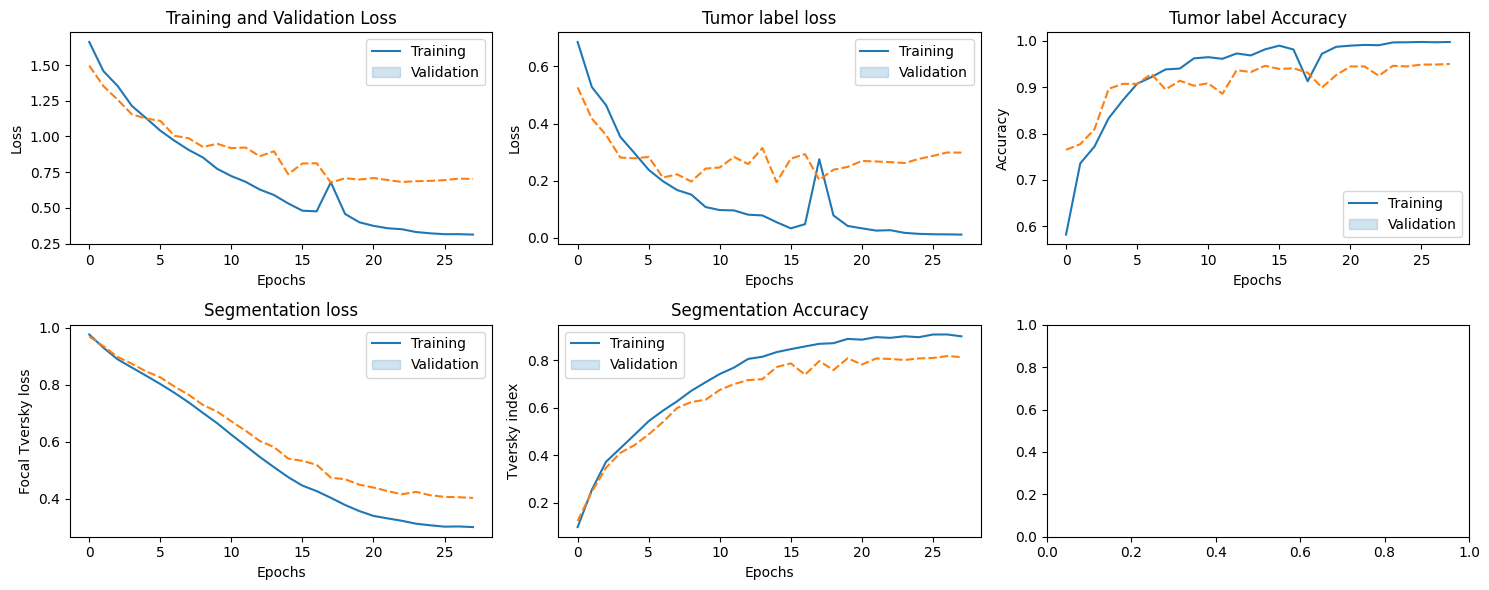

In [ ]:
import seaborn as sns

# Prepare pandas DataFrame
df_history = pd.DataFrame(history.history)

# Plot side-by-side
fig, ax1 = plt.subplots(nrows=2, ncols=3, figsize=(15,6))

sns.lineplot(data=df_history[["loss","val_loss"]], ax=ax1[0,0])
ax1[0,0].set_xlabel('Epochs')
ax1[0,0].set_ylabel('Loss')
ax1[0,0].legend(labels=["Training", "Validation"])
ax1[0,0].set_title('Training and Validation Loss')

sns.lineplot(data=df_history[['tumor_label_loss','val_tumor_label_loss']], ax=ax1[0,1])
ax1[0,1].set_xlabel('Epochs')
ax1[0,1].set_ylabel('Loss')
ax1[0,1].legend(labels=["Training", "Validation"])
ax1[0,1].set_title('Tumor label loss')

sns.lineplot(data=df_history[['tumor_label_accuracy','val_tumor_label_accuracy']], ax=ax1[0,2])
ax1[0,2].set_xlabel('Epochs')
ax1[0,2].set_ylabel('Accuracy')
ax1[0,2].legend(labels=["Training", "Validation"])
ax1[0,2].set_title('Tumor label Accuracy')

sns.lineplot(data=df_history[['seg_loss','val_seg_loss']], ax=ax1[1,0])
ax1[1,0].set_xlabel('Epochs')
ax1[1,0].set_ylabel('Focal Tversky loss')
ax1[1,0].legend(labels=["Training", "Validation"])
ax1[1,0].set_title('Segmentation loss')

sns.lineplot(data=df_history[['seg_tversky','val_seg_tversky']], ax=ax1[1,1])
ax1[1,1].set_xlabel('Epochs')
ax1[1,1].set_ylabel('Tversky index')
ax1[1,1].legend(labels=["Training", "Validation"])
ax1[1,1].set_title('Segmentation Accuracy')
plt.tight_layout()
plt.show()
fig.delaxes(ax1[1][2])

In [ ]:
#============save the model architecture into json file=========================
"""# save the model architecture to json file for future use"""

model_json = model.to_json()
with open("models/Multi-task-Seg-model.json","w") as json_file:
  json_file.write(model_json)

#======== save the model into hdf5==============================================
#model.save('./Seg_multi-task.hdf5')

**Model metrics evaluation**

In [ ]:
test_generator = tf_DataGenerator(image_test_path, mask_test_path, test_label)
batch_x, (batch_label, batch_mask) = test_generator[0]

In [ ]:
print(batch_x.shape)

(32, 256, 256, 3)


In [ ]:
def real_predict(model, filenames):
  label = []
  seg = []
  x_input = ([(preprocess_input(cv2.imread(file_name))) for file_name in filenames])
  for x_i in x_input:
      #x = np.expand_dims(x_i, axis=0)
      img = np.reshape(x_i, (1,256,256,3))
      pred = model.predict(img, verbose = 0)
      label.append(np.argmax(pred[0]))
      seg.append(pred[1])
  return label, seg

1/1 [==============================] - 1s 1s/step
Accuracy: 90.62%
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        20
           1       0.80      1.00      0.89        12

    accuracy                           0.91        32
   macro avg       0.90      0.93      0.90        32
weighted avg       0.93      0.91      0.91        32



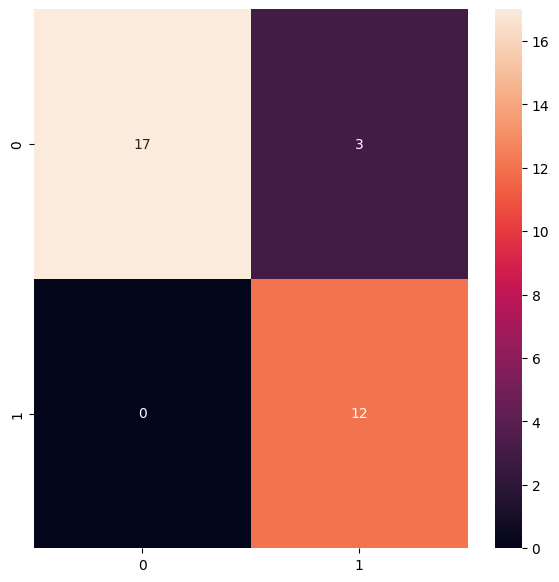

In [ ]:

#load the model architecure and saved best weight
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.metrics import MeanIoU

# model = load_model("Seg_multi-task.hdf5",
#                    custom_objects={'focal_tversky': focal_tversky,
#                                    'tversky':tversky})

model = load_model("Seg_multi-task-v2.hdf5", compile=False)

# metrics evaluation

pred = model.predict(batch_x)

# Obtain the predicted class from the model prediction
predict = []

for i in pred[0]:
    predict.append(str(np.argmax(i)))

label_predict = np.asarray(predict)
true_label = np.asarray(test_label)[:len(label_predict)]

#===prediction accuracy=========================================================

accuracy = accuracy_score(label_predict, true_label)
print('Accuracy: {0:.2f}%'.format(accuracy * 100.0))

#===========print confusion matrix of the prediction============================

cm = confusion_matrix(label_predict, true_label)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

# #==============classification report============================================
report = classification_report(label_predict, true_label)   #, labels = ['No Tumor','Tumor present']
print(report)


In [ ]:
pred[1][0].shape

(256, 256, 1)

In [ ]:
#test_predict[1][3].squeeze()
print(label_predict)
print(true_label)

['0' '0' '0' '1' '0' '1' '0' '1' '1' '0' '0' '1' '0' '1' '0' '0' '0' '0'
 '1' '1' '0' '1' '0' '1' '0' '0' '0' '1' '0' '0' '1' '0']
['0' '0' '0' '1' '0' '1' '0' '1' '1' '1' '1' '1' '0' '1' '0' '1' '0' '0'
 '1' '1' '0' '1' '0' '1' '0' '0' '0' '1' '0' '0' '1' '0']


In [ ]:
pred[1][3]

In [ ]:
# df_pred = pd.DataFrame({'has_mask': test_predict[0]})  #'predicted_mask': test_predict[1], 'image_path': image_test_path,
# df_pred

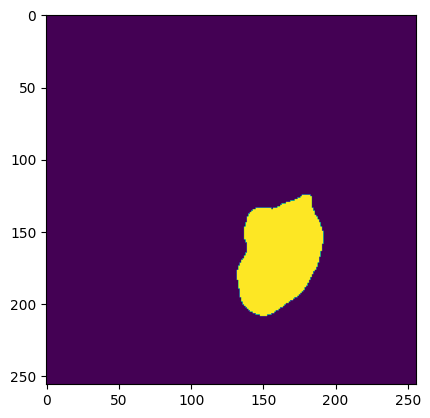

In [ ]:
predicted_mask = np.asarray(pred[1][5]).squeeze().round()
#plt.title.set_text("Model Predicted Mask")
plt.imshow(predicted_mask)

**Model prediction Testing**

In [70]:
###==========ploting the prediction=============================================

fig, axs = plt.subplots(10, 5, figsize=(50,150))
for i in range(10):
      # read the images and convert them to RGB format image_test_path
      imga = io.imread(image_test_path[i])
      #imga = np.array(batch_x[i])
      img = cv2.cvtColor(imga, cv2.COLOR_BGR2RGB)
      axs[i][0].set_title("Brain MRI", fontsize=30)
      axs[i][0].imshow(img)

      # Obtain the mask for the image
      mask = io.imread(mask_test_path[i])
      #mask = np.array(batch_mask[i])
      axs[i][1].set_title("Original Mask", fontsize=30)
      axs[i][1].imshow(mask)

      # Obtain the predicted mask for the image
      predicted_mask = np.asarray(pred[1][i]).squeeze().round()
      axs[i][2].set_title("Predicted Mask", fontsize=30)
      axs[i][2].imshow(predicted_mask)

      #Obtain the predicted label
      label = np.argmax(pred[0][i])
      if label == 0:
        label = 'No Tumor'
      else:
        label = 'Tumor present'

      # Apply the mask to the image 'mask==255'
      img[mask == 255] = (255, 0, 0)
      axs[i][3].set_title("MRI with Original Mask", fontsize=30)
      axs[i][3].imshow(img)

    # MRI with predicted label and mask========================================= np.array(batch_x[i])
      img_ = io.imread(image_test_path[i])
      #img_ = np.array(batch_x[i])
      img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
      img_[predicted_mask == 1] = (0,225,0)
      axs[i][4].set_title(label, fontsize=40)
      axs[i][4].imshow(img_)
fig.tight_layout()

**Deployment prediction using trained Model**

In [ ]:

#=== provide data =================
image = input('Input the image URL or insert MRI')

def Brain_tumor_prediction(image):
  IMAGE_SIZE = 256
  # Resize the image
  img = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])

  # preprocess the image
  img = tf.keras.applications.resnet50.preprocess_input(img)

  #======load model================================
  model = load_model("Seg_multi-task-v2.hdf5", compile=False)

  imag = tf.expand_dims(img, axis=0)

  #==== detect tumor and locate it======
  predict = model.predict(imag)

  #plot the result and label
  mri = io.imread(img)
  img_ = cv2.cvtColor(mri, cv2.COLOR_BGR2RGB)

  #Obtain the predicted label
  label = np.argmax(pred[0])
  if label == 0:
      label = 'No Tumor'
  else:
      label = 'Tumor present'

  #=============predicted MRI mask==========================
  predicted_mask = np.asarray(predict[1])[0].squeeze().round()

  #== plot the prediction and label
  img_[predicted_mask == 1] = (0, 255, 0)
  plt.title.set_text(label, fontsize=40)
  plt.imshow(img_)
  fig.tight_layout()

## Others



In [ ]:
# """Deeplab3+ Atrous Spatial Pyramid Pooling"""

# import os
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# from tensorflow.keras.layers import (
#     Input, AveragePooling2D, Conv2D, BatchNormalization, Activation, UpSampling2D,
#     Flatten, Dense, Dropout, Concatenate, Add
# )
# from tensorflow.keras.models import Model
# from tensorflow.keras.applications import ResNet50
# import tensorflow as tf

# """ Atrous Spatial Pyramid Pooling """
# def ASPP(inputs):
#     shape = inputs.shape

#     y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
#     y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
#     y_pool = BatchNormalization(name=f'bn_1')(y_pool)
#     y_pool = Activation('relu', name=f'relu_1')(y_pool)
#     y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

#     dilations = [1, 6, 12]  # Dilation rates for the ASPP module
#     y_aspp = []
#     for dilation in dilations:
#         y = Conv2D(filters=256, kernel_size=3, dilation_rate=dilation, padding='same', use_bias=False)(inputs)
#         y = BatchNormalization()(y)
#         y = Activation('relu')(y)
#         y_aspp.append(y)

#     y = Concatenate()(y_aspp + [y_pool])

#     y = Conv2D(filters=128, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
#     y = BatchNormalization()(y)
#     y = Activation('relu')(y)
#     return y

# def classification_part(inputs, num_classes):
#     x = AveragePooling2D(pool_size=(4, 4))(inputs)
#     x = Flatten(name='flatten')(x)
#     dense_units = [256, 256, 128, 64, 64]
#     for units in dense_units:
#         x = Dense(units, activation='relu')(x)
#         x = Dropout(0.3)(x)
#     tumor_label = Dense(num_classes, activation='sigmoid', name='tumor_label')(x)
#     return tumor_label

# def Modified_DeepLabV3Plus(shape, num_classes):
#     """ Inputs """
#     inputs = Input(shape)

#     """ Pre-trained ResNet50 """
#     base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

#     # Freeze the model weights
#     for layer in base_model.layers:
#         layer.trainable = False

#     # =========classification part===============================================
#     tumor_label = classification_part(base_model.output, num_classes)

#     # ==============Segmentation part============================================
#     """ Pre-trained ResNet50 Output """
#     image_features = base_model.get_layer('conv4_block6_out').output
#     x_a = ASPP(image_features)
#     x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

#     """ Get low-level features """
#     x_b = base_model.get_layer('conv2_block2_out').output
#     x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
#     x_b = BatchNormalization()(x_b)
#     x_b = Activation('relu')(x_b)

#     x = Concatenate()([x_a, x_b])

#     x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = UpSampling2D((4, 4), interpolation="bilinear")(x)

#     """ Outputs """
#     seg = Conv2D(num_classes, (1, 1), padding="same", name='seg')(x)  # activation = "sigmoid",

#     """ Model """
#     model = Model(inputs=inputs, outputs=[tumor_label, seg])
#     return model


In [ ]:
# def read_image(image_path, mask=False):
#     image = tf.io.read_file(image_path)
#     if mask:
#         image = tf.image.decode_png(image, channels=1)
#         image.set_shape([None, None, 1])
#         image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE]) / 255.0
#         # convert label to categorical data or one-hot encoder
#         # n_classes = len(np.unique(image))
#         # image = to_categorical(labels, num_classes=n_classes)
#     else:
#         image = tf.image.decode_png(image, channels=3)
#         image.set_shape([None, None, 3])
#         image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
#         image = tf.keras.applications.resnet50.preprocess_input(image)
#     return image



# ####================== load data in batches for training =======================
# from keras.utils import to_categorical

# def label_encoder(train_label):
#   n_classes = len(np.unique(train_label))
#   label = to_categorical(train_label, num_classes=n_classes)
#   return label

# def load_data(image_list, mask_list, train_label):
#     image = read_image(image_list)
#     mask = read_image(mask_list, mask=True)
#     label = train_label
#     return image, label, mask

# def data_generator(image_list, mask_list, train_label):
#     label = label_encoder(train_label)
#     dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list, label))
#     dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
#     dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
#     return dataset

In [ ]:
#=====segmentation metrics======================================================
#IOU
# seg_pred = pred[1]
# y_pred_argmax=np.argmax(seg_pred, axis=1)
# y_test_argmax=np.argmax(batch_mask, axis=1)

# #=================Using built in keras function for IoU=========================

# n_classes = 2
# IOU_keras = MeanIoU(num_classes=n_classes)
# IOU_keras.update_state(y_test_argmax, y_pred_argmax)
# print("Mean IoU =", IOU_keras.result().numpy())